In [1]:
from pathlib import Path
import sys

In [5]:
path_repaint = Path() / 'RePaint'

if not path_repaint.exists():
  # !rm -rf *
  ! git clone https://github.com/andreas128/RePaint.git
  ! pip install numpy torch blobfile tqdm pyYaml pillow
  ! pip install --upgrade gdown && bash {path_repaint / 'download.sh'}
  sys.path.append(path_repaint.absolute().as_posix()) 
  # !pip install torch-summary
else:
  print("Found downloaded stuff.")

Found downloaded stuff.


In [6]:

import os
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from pathlib import Path
import blobfile as bf
from torchsummary import summary
import matplotlib.pyplot as plt

# # Workaround
# try:
#     import ctypes
#     libgcc_s = ctypes.CDLL('libgcc_s.so.1')
# except:
#     pass

from guided_diffusion.unet import (
    UNetModel
)  

from guided_diffusion.respace import (
    SpacedDiffusion,
    space_timesteps
)

import guided_diffusion.gaussian_diffusion as gd


from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args
)  # noqa: E402

from guided_diffusion.image_datasets import (
    load_data_inpa
)


debug = False

print("Pytorch: \t\t", th.__version__)
if not debug and th.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', th.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(th.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(th.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    th.backends.cudnn.benchmark = True
else:
    if debug:
      print("Using cpu in debug mode")
    else:
      print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.13.0+cu116
GPU:         		 NVIDIA GeForce GTX 1660 Ti
Memory Usage:	 0.0 GB /  0.0 GB


In [7]:

def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample

  
  
def list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(list_image_files_recursively(full_path))
    return results

In [8]:
conf_path = (path_repaint / 'confs/face_example.yml').absolute()
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread(conf_path))
conf

Default_Conf(None,
             {'attention_resolutions': '32,16,8',
              'class_cond': False,
              'diffusion_steps': 1000,
              'learn_sigma': True,
              'noise_schedule': 'linear',
              'num_channels': 256,
              'num_head_channels': 64,
              'num_heads': 4,
              'num_res_blocks': 2,
              'resblock_updown': True,
              'use_fp16': False,
              'use_scale_shift_norm': True,
              'classifier_scale': 4.0,
              'lr_kernel_n_std': 2,
              'num_samples': 100,
              'show_progress': True,
              'timestep_respacing': '250',
              'use_kl': False,
              'predict_xstart': False,
              'rescale_timesteps': False,
              'rescale_learned_sigmas': False,
              'classifier_use_fp16': False,
              'classifier_width': 128,
              'classifier_depth': 2,
              'classifier_attention_resolutions': '32,16,

In [9]:
select_args(conf, model_and_diffusion_defaults().keys())


{'image_size': 256,
 'num_channels': 256,
 'num_res_blocks': 2,
 'num_heads': 4,
 'num_heads_upsample': -1,
 'num_head_channels': 64,
 'attention_resolutions': '32,16,8',
 'channel_mult': '',
 'dropout': 0.0,
 'class_cond': False,
 'use_checkpoint': False,
 'use_scale_shift_norm': True,
 'resblock_updown': True,
 'use_fp16': False,
 'use_new_attention_order': False,
 'learn_sigma': True,
 'diffusion_steps': 1000,
 'noise_schedule': 'linear',
 'timestep_respacing': '250',
 'use_kl': False,
 'predict_xstart': False,
 'rescale_timesteps': False,
 'rescale_learned_sigmas': False}

In [10]:
#Unet
image_size = 256
attention_resolutions = [32, 16, 8]
num_channels = 256
learn_sigma = True
num_res_blocks = 2
dropout = 0
use_fp16 = False
num_heads = 4
num_head_channels = 64
num_heads_upsample = -1
use_scale_shift_norm = True
resblock_updown = True

#Diffusion
diffusion_steps = 1000
timestep_respacing = 250
noise_schedule = 'linear'

images_path = './data/datasets/gts/face'
mask_path = './data/datasets/gt_keep_masks/face'
batch_size = 1

In [11]:

# conf = None
# print("Starting sampling...")

# model, diffusion = create_model_and_diffusion(
#     **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
# )

print("Initializing UNetModel ...")

if image_size == 512:
    channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
elif image_size == 256:
    channel_mult = (1, 1, 2, 2, 4, 4)
elif image_size == 128:
    channel_mult = (1, 1, 2, 3, 4)
elif image_size == 64:
    channel_mult = (1, 2, 3, 4)
else:
    raise ValueError(f"unsupported image size: {image_size}")

attention_ds = []
for res in attention_resolutions:
    attention_ds.append(image_size // res)

model = UNetModel(
    image_size=image_size,
    in_channels=3,
    model_channels=num_channels,
    out_channels=(3 if not learn_sigma else 6),
    num_res_blocks=num_res_blocks,
    attention_resolutions=tuple(attention_ds),
    dropout=dropout,
    channel_mult=channel_mult,
    num_classes=None,
    use_checkpoint=False,
    use_fp16=use_fp16,
    num_heads=num_heads,
    num_head_channels=num_head_channels,
    num_heads_upsample=num_heads_upsample,
    use_scale_shift_norm=use_scale_shift_norm,
    resblock_updown=resblock_updown,
    use_new_attention_order=False,
    conf=conf
)

model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)

model.to(device)
if use_fp16:
    model.convert_to_fp16()
model.eval()

# diffusion = create_gaussian_diffusion(
#     steps=diffusion_steps,
#     learn_sigma=learn_sigma,
#     noise_schedule=noise_schedule,
#     use_kl=use_kl,
#     predict_xstart=predict_xstart,
#     rescale_timesteps=rescale_timesteps,
#     rescale_learned_sigmas=rescale_learned_sigmas,
#     timestep_respacing=timestep_respacing,
#     conf=conf
# )

print("Initializing SpacedDiffusion ...")

betas = gd.get_named_beta_schedule(noise_schedule, diffusion_steps, use_scale=True)

if conf.use_value_logger:
    conf.value_logger.add_value(
        betas, 'betas create_gaussian_diffusion')

loss_type = gd.LossType.MSE

diffusion = SpacedDiffusion(
    use_timesteps=space_timesteps(diffusion_steps, timestep_respacing),
    betas=betas,
    model_mean_type=gd.ModelMeanType.EPSILON,
    model_var_type=gd.ModelVarType.LEARNED_RANGE,
    loss_type=loss_type,
    rescale_timesteps=False,
    conf=conf
)
    


Initializing UNetModel ...
Initializing SpacedDiffusion ...


In [13]:

show_progress = True
cond_fn = None

print("sampling...")
# all_images = []

# dset = 'eval'

# eval_name = conf.get_default_eval_name()
# print("Eval Name:", eval_name)

print(f"Reading images from: {images_path}")
print(f"Reading masks from: {mask_path}")

dl = load_data_inpa(
    gt_path=images_path,
    mask_path=mask_path,
    batch_size=batch_size,
    image_size=image_size,
    class_cond=False,
    deterministic=True,
    return_dataloader=True,
    return_dict=True,
    max_len=8,
    drop_last=False,
    conf=conf
)

# for batch in iter(dl):
batch = next(iter(dl))

print("sampling complete")

sampling...
Reading images from: ./data/datasets/gts/face
Reading masks from: ./data/datasets/gt_keep_masks/face
sampling complete


In [14]:
batch.keys(), batch['GT_name']

(dict_keys(['GT', 'GT_name', 'gt_keep_mask']), ['000000.png'])

Image Size:  (256, 256, 3)
Image Size as per conf:  256


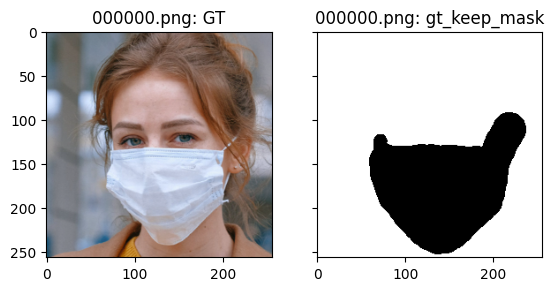

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

image = toU8(batch['GT'])[0]
# [0].permute(1,2,0).numpy()
# image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
# image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])

ax1.imshow(image)
ax1.set_title(batch['GT_name'][0] + ": GT")

image = batch['gt_keep_mask'][0].permute(1,2,0).numpy()
ax2.imshow(image)
ax2.set_title(batch['GT_name'][0] + ": gt_keep_mask")

print("Image Size: ", image.shape)
print("Image Size as per conf: ", conf.image_size)

In [26]:
summary(model)

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Linear: 2-1                                 263,168
|    └─SiLU: 2-2                                   --
|    └─Linear: 2-3                                 1,049,600
├─ModuleList: 1-2                                  --
|    └─TimestepEmbedSequential: 2-4                --
|    |    └─Conv2d: 3-1                            7,168
|    └─TimestepEmbedSequential: 2-5                --
|    |    └─ResBlock: 3-2                          1,705,984
|    └─TimestepEmbedSequential: 2-6                --
|    |    └─ResBlock: 3-3                          1,705,984
|    └─TimestepEmbedSequential: 2-7                --
|    |    └─ResBlock: 3-4                          1,705,984
|    └─TimestepEmbedSequential: 2-8                --
|    |    └─ResBlock: 3-5                          1,705,984
|    └─TimestepEmbedSequential: 2-9                --
|    |    └─ResBlock: 3-6         

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Linear: 2-1                                 263,168
|    └─SiLU: 2-2                                   --
|    └─Linear: 2-3                                 1,049,600
├─ModuleList: 1-2                                  --
|    └─TimestepEmbedSequential: 2-4                --
|    |    └─Conv2d: 3-1                            7,168
|    └─TimestepEmbedSequential: 2-5                --
|    |    └─ResBlock: 3-2                          1,705,984
|    └─TimestepEmbedSequential: 2-6                --
|    |    └─ResBlock: 3-3                          1,705,984
|    └─TimestepEmbedSequential: 2-7                --
|    |    └─ResBlock: 3-4                          1,705,984
|    └─TimestepEmbedSequential: 2-8                --
|    |    └─ResBlock: 3-5                          1,705,984
|    └─TimestepEmbedSequential: 2-9                --
|    |    └─ResBlock: 3-6         

In [16]:
# conf['schedule_jump_params'] = {'t_T': 250, 'n_sample': 1, 'jump_length': 10, 'jump_n_sample': 10}

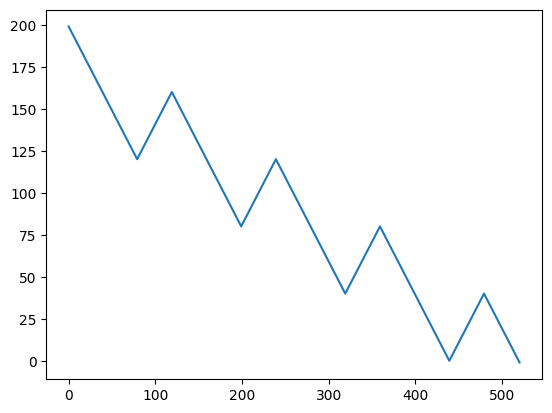

In [20]:
from guided_diffusion.scheduler import get_schedule_jump

conf['schedule_jump_params'] = schedule = {'t_T': 250,
               'n_sample': 1,
               'jump_length': 40,
               'jump_n_sample': 2}

plt.plot(get_schedule_jump(**schedule))

In [21]:

for k in batch.keys():
    if isinstance(batch[k], th.Tensor):
        batch[k] = batch[k].to(device)


def model_fn(x, t, y=None, gt=None, **kwargs):
    # assert y is not None
    return model(x, t, None, gt=gt)

model_kwargs = {}

model_kwargs["gt"] = batch['GT'].to(device)
model_kwargs['gt_keep_mask'] = batch['gt_keep_mask'].to(device)

assert batch_size == model_kwargs["gt"].shape[0]

result = diffusion.p_sample_loop(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=True,
    conf=conf
)

# ~ 3.5 mins per image using an A100
# ~ 2.5 mins per image on 

  0%|          | 0/520 [00:00<?, ?it/s]

In [22]:
result.keys()

dict_keys(['sample', 'pred_xstart', 'gt'])

In [23]:
srs = toU8(result['sample'])
gts = toU8(result['gt'])
lrs = toU8(result['pred_xstart'])
srs = toU8(result.get('gt') * model_kwargs.get('gt_keep_mask') + (-1) *
           th.ones_like(result.get('gt')) * (1 - model_kwargs.get('gt_keep_mask')))

gt_keep_masks = toU8((model_kwargs.get('gt_keep_mask') * 2 - 1))

# conf.eval_imswrite(
#     srs=srs, gts=gts, lrs=lrs, gt_keep_masks=gt_keep_masks,
#     img_names=batch['GT_name'], dset=dset, name=eval_name, verify_same=False)
print("sampling complete")

sampling complete


Text(0.5, 1.0, '000000.png: gt_keep_masks')

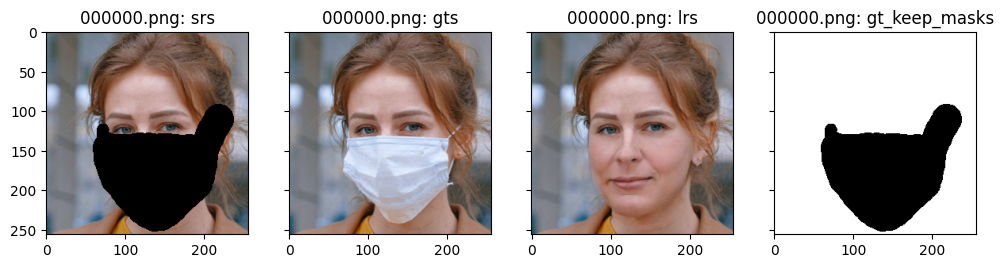

In [24]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12, 4))

ax1.imshow(srs[0])
ax1.set_title(batch['GT_name'][0] + ": srs")

ax2.imshow(gts[0])
ax2.set_title(batch['GT_name'][0] + ": gts")

ax3.imshow(lrs[0])
ax3.set_title(batch['GT_name'][0] + ": lrs")

ax4.imshow(gt_keep_masks[0])
ax4.set_title(batch['GT_name'][0] + ": gt_keep_masks")

Text(0.5, 1.0, '000000.png: gt_keep_masks')

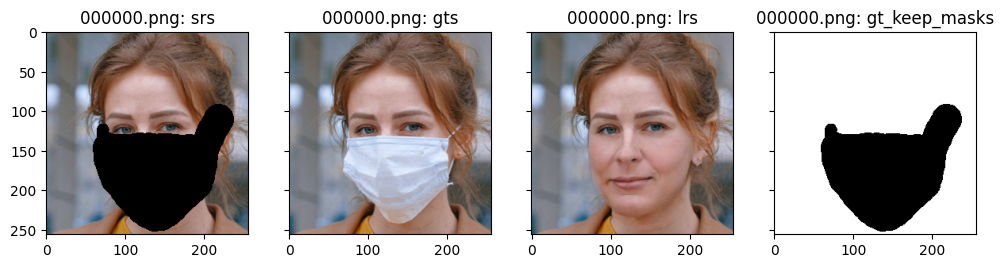

In [25]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12, 4))

ax1.imshow(srs[0])
ax1.set_title(batch['GT_name'][0] + ": srs")

ax2.imshow(gts[0])
ax2.set_title(batch['GT_name'][0] + ": gts")

ax3.imshow(lrs[0])
ax3.set_title(batch['GT_name'][0] + ": lrs")

ax4.imshow(gt_keep_masks[0])
ax4.set_title(batch['GT_name'][0] + ": gt_keep_masks")